In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
X = pd.read_csv("titanic.csv")
y = X['Survived'].values

In [3]:
X.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode())

# Age Binning
X['AgeBin'] = pd.cut(X['Age'], bins=[0, 18, 35, 60, 100], labels=[0, 1, 2, 3])
X.drop(['Age'], axis=1, inplace=True)

X = pd.get_dummies(X, columns=['Embarked','Sex','AgeBin'])


X = X.astype(float)

In [4]:
# Normalizing the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Outlier removal based on Z-score
X = X[(X.abs() <= 3).all(axis=1)]
y = y[X.index]

In [5]:
correlation_matrix = X.corr()
mat = pd.DataFrame(correlation_matrix['Survived'])
print(mat)

            Survived
Survived    1.000000
Pclass     -0.365972
SibSp       0.092244
Parch       0.227611
Fare        0.354965
Embarked_C  0.164812
Embarked_Q       NaN
Embarked_S -0.168614
Sex_female  0.536862
Sex_male   -0.536862
AgeBin_0    0.149932
AgeBin_1   -0.123921
AgeBin_2    0.017048
AgeBin_3         NaN


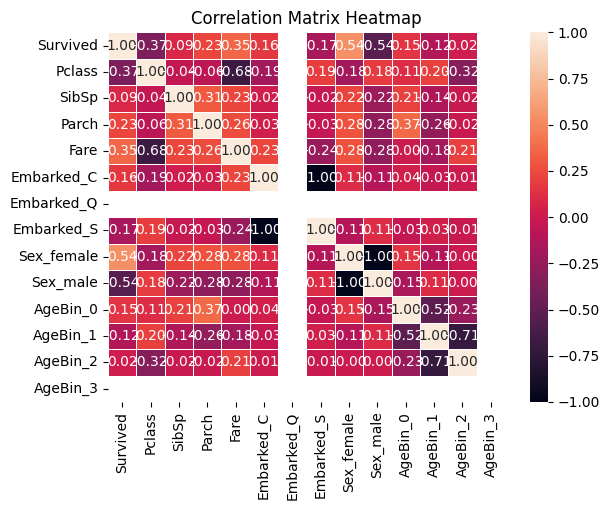

In [6]:
sns.heatmap(correlation_matrix, annot = True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
X.drop(['Survived','Embarked_Q','AgeBin_2','AgeBin_3','SibSp'], axis=1, inplace= True)

# Adding bias term to X
X = np.hstack((X, np.ones((X.shape[0], 1))))

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def predict(X, weights):
    Z = np.dot(X, weights)
    A = sigmoid(Z)
    return (A > 0.5).astype(int)

In [10]:
def gradient_descent(X, y, weights, learning_rate, num_iterations):
    m = len(X)
    cost_history = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        Z = np.dot(X, weights)
        A = sigmoid(Z)
        gradient = (1/m) * np.dot(X.T, (A - y.reshape(-1, 1)))
        weights -= learning_rate * gradient
        cost_history[i] = -np.mean(np.dot(y, np.log(A)) + np.dot((1 - y), np.log(1 - A)))
        # print(f"Iteration {i}, Cost: {cost_history[i]}")
        
    return weights, cost_history

In [11]:
#Train Test Split
ratio = 0.8

rows = X.shape[0]
train_size = int(ratio*rows)

X_train = X[0:train_size]
X_test = X[train_size:]

y_train = y[0:train_size]
y_test = y[train_size:]

In [12]:
# Training the model
weights = np.zeros((X.shape[1], 1))
learning_rate = 0.01
num_iterations = 700

weights, costs = gradient_descent(X_train, y_train, weights, learning_rate, num_iterations)

# Predictions and accuracy
predictions = predict(X_test, weights)


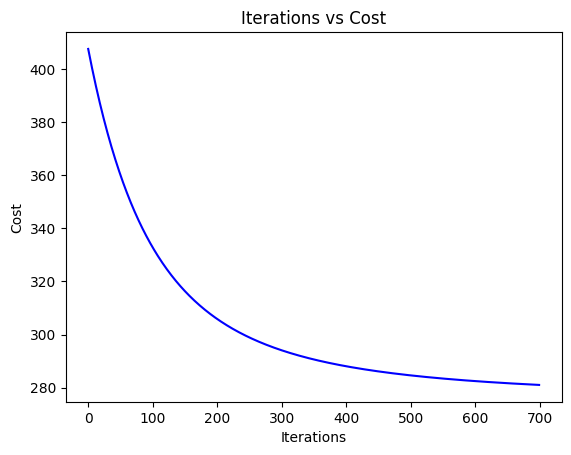

In [13]:
# Plotting the iterations vs cost
plt.plot(range(num_iterations), costs, 'b-')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Iterations vs Cost")
plt.show()

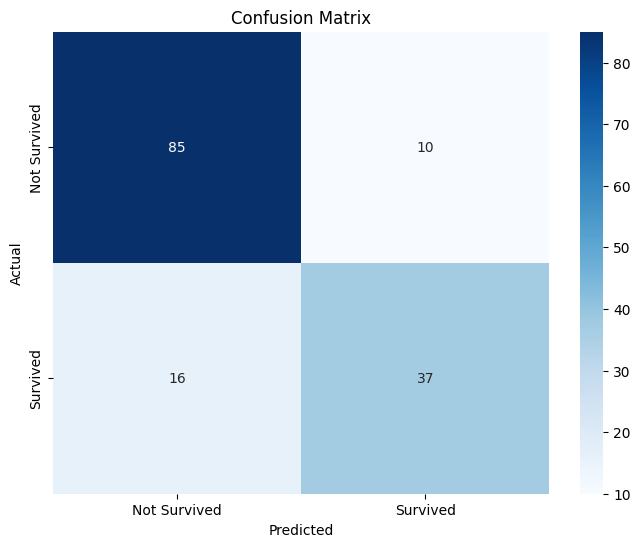

In [14]:
# Confusion Matrix (Manual Calculation)
TP = np.sum((predictions == 1) & (y_test.reshape(-1, 1) == 1))
TN = np.sum((predictions == 0) & (y_test.reshape(-1, 1) == 0))
FP = np.sum((predictions == 1) & (y_test.reshape(-1, 1) == 0))
FN = np.sum((predictions == 0) & (y_test.reshape(-1, 1) == 1))

conf_matrix = np.array([[TN, FP], [FN, TP]])

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
train_predictions = predict(X_train, weights)
accuracy_train = np.mean(train_predictions == y_train.reshape(-1, 1)) * 100
print(f"Training Accuracy: {accuracy_train}%")

# Calculate accuracy on test set
accuracy_test = np.mean(predictions == y_test.reshape(-1, 1)) * 100
print(f"Test Accuracy: {accuracy_test}%")

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision}")
print(f"Recall(Sensitivity): {recall}")
print(f"F1 Score: {f1_score}")

Training Accuracy: 77.89115646258503%
Test Accuracy: 82.43243243243244%

Precision: 0.7872340425531915
Recall(Sensitivity): 0.6981132075471698
F1 Score: 0.74
